In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import matplotlib.pyplot as plt

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads

        # Initialise Projection matrices
        self.W_q = nn.Linear(d_model, d_model, bias = False)
        self.W_k = nn.Linear(d_model, d_model, bias = False)
        self.W_v = nn.Linear(d_model, d_model, bias = False)

        # Output Projection
        self.W_o = nn.Linear(d_model, d_model, bias = False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        # x is of shape [batch_size, seq_len, d_model]
        batch_size, seq_len, _ = x.shape

        # Linear projections
        q = self.W_q(x) # [batch_size, seq_len, d_model]
        k = self.W_k(x) # [batch_size, seq_len, d_model]
        v = self.W_v(x) # [batch_size, seq_len, d_model]

        # Reshaping for multi-head attention
        # [batch_size, seq_len, d_model] -> [batch_size, seq_len, num_heads, head_dim]
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim)

        # [batch_size, seq_len, num_heads, head_dim] -> [batch_size, num_heads, seq_len, head_dim]
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)

        # Computing attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim) # [batch_size, num_heads, seq_len, seq_len]

        # Mask for causal attention
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax to get attention weights
        # [batch_size, num_heads, seq_len, seq_len]
        attention_weights = F.softmax(scores, dim = -1)
        # Softmax along dim = -1 to determine how much attention along each key dimension

        # Applying dropout to attention weights
        attention_weights = self.dropout(attention_weights)

        # Applying attention weights to valyues
        # [batch_size, num_heads, seq_len, head_dim]
        context = torch.matmul(attention_weights, v)

        # Concatenating heads
        # [batch_size, num_heads, seq_len, head_dim] -> [batch_size, seq_len, num_heads, head_dim]
        context = context.transpose(1, 2)
        # [batch_size, num_heads, seq_len, head_dim] -> [batch_size, seq_len, d_model]
        context = context.contiguous().view(batch_size, seq_len, self.d_model)

        # Output projection
        output = self.W_o(context)

        return output


### Creating causal mask

In [11]:
def create_causal_mask(seq_len):
    # Lower tringular matrix so that query tokens dont have access to keys that come after them in the sequence
    mask = torch.tril(torch.ones((seq_len, seq_len)))

    return mask.unsqueeze(0).unsqueeze(0) # [1, 1, seq_len, seq_len]

In [12]:
def benchmark_attention(model, seq_lengths, batch_size=1, d_model=512, num_runs=10):
    results = []

    for seq_len in seq_lengths:
        x = torch.randn(batch_size, seq_len, d_model).cuda()

        # Warm up
        for _ in range(3):
            _ = model(x)
        torch.cuda.synchronize()

        torch.cuda.synchronize()
        start_time = time.time()

        for _ in range(num_runs):
            _ = model(x)
            torch.cuda.synchronize()

        end_time = time.time()
        avg_time = (end_time - start_time) / num_runs

        torch.cuda.reset_peak_memory_stats()
        _ = model(x)
        torch.cuda.synchronize()
        memory_used = torch.cuda.max_memory_allocated() / (1024 ** 2)  # MB

        results.append((seq_len, avg_time * 1000, memory_used))  # time in ms
        print(f"Seq len: {seq_len}, Time: {avg_time*1000:.2f} ms, Memory: {memory_used:.2f} MB")

    return results

In [13]:
def benchmark_and_analyze():
    d_model = 768
    num_heads = 12
    model = MultiHeadAttention(d_model, num_heads).cuda()

    seq_lengths = [128, 256, 512, 1024, 2048, 4096]

    results = benchmark_attention(model, seq_lengths, d_model=d_model)

    seq_lens, times, memories = zip(*results)

    # Plot results
    plt.figure(figsize=(12, 5))

    # Time plot
    plt.subplot(1, 2, 1)
    plt.plot(seq_lens, times, 'o-')
    plt.title('Attention Latency vs Sequence Length')
    plt.xlabel('Sequence Length')
    plt.ylabel('Time (ms)')
    plt.grid(True)

    # Memory plot
    plt.subplot(1, 2, 2)
    plt.plot(seq_lens, memories, 'o-')
    plt.title('Memory Usage vs Sequence Length')
    plt.xlabel('Sequence Length')
    plt.ylabel('Memory (MB)')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('attention_benchmark.png')

    # Analyze quadratic scaling
    print("\nQuadratic Scaling Analysis:")
    for i in range(1, len(seq_lengths)):
        seq_ratio = seq_lengths[i] / seq_lengths[i-1]
        time_ratio = times[i] / times[i-1]
        memory_ratio = memories[i] / memories[i-1]

        print(f"Seq length: {seq_lengths[i-1]} → {seq_lengths[i]}")
        print(f"  Sequence ratio: {seq_ratio:.2f}x")
        print(f"  Time ratio: {time_ratio:.2f}x (expected {seq_ratio**2:.2f}x for O(n²))")
        print(f"  Memory ratio: {memory_ratio:.2f}x (expected {seq_ratio**2:.2f}x for O(n²))")

Seq len: 128, Time: 0.52 ms, Memory: 25.38 MB
Seq len: 256, Time: 0.52 ms, Memory: 41.88 MB
Seq len: 512, Time: 0.57 ms, Memory: 100.12 MB
Seq len: 1024, Time: 2.39 ms, Memory: 314.62 MB
Seq len: 2048, Time: 8.40 ms, Memory: 1139.12 MB
Seq len: 4096, Time: 31.23 ms, Memory: 4373.12 MB

Quadratic Scaling Analysis:
Seq length: 128 → 256
  Sequence ratio: 2.00x
  Time ratio: 0.98x (expected 4.00x for O(n²))
  Memory ratio: 1.65x (expected 4.00x for O(n²))
Seq length: 256 → 512
  Sequence ratio: 2.00x
  Time ratio: 1.11x (expected 4.00x for O(n²))
  Memory ratio: 2.39x (expected 4.00x for O(n²))
Seq length: 512 → 1024
  Sequence ratio: 2.00x
  Time ratio: 4.18x (expected 4.00x for O(n²))
  Memory ratio: 3.14x (expected 4.00x for O(n²))
Seq length: 1024 → 2048
  Sequence ratio: 2.00x
  Time ratio: 3.52x (expected 4.00x for O(n²))
  Memory ratio: 3.62x (expected 4.00x for O(n²))
Seq length: 2048 → 4096
  Sequence ratio: 2.00x
  Time ratio: 3.72x (expected 4.00x for O(n²))
  Memory ratio: 3.8

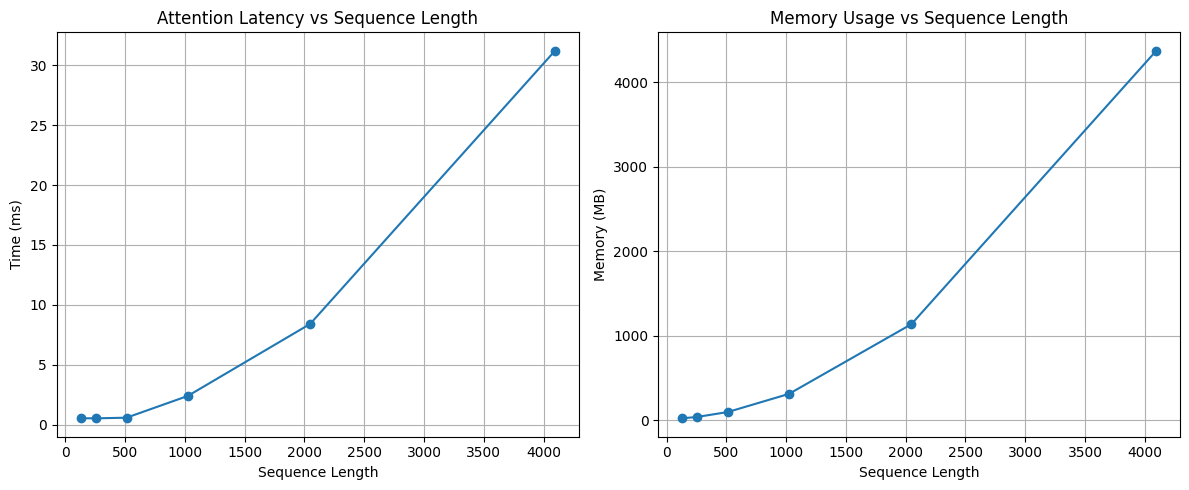

In [14]:
benchmark_and_analyze()